# Tarea 1: Bandits y Exploracion/Explotacion

En este notebook se va a mostrar:
- Algoritmo Bandit
- Mostrar el effecto de epislon en la exploracion y aprender sobre el balance de la exploracion y la explotacion
- Introducir un poco en el aprendizaje reforzado

Se hará uso de RL-Glue para crear los escenarios.

## 1. Importando bibliotecas

In [6]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env
from tqdm import tqdm
import time

## 2.  Agente Greedy

Queremos crear un agente que encuentre la acción con la recompensa más alta esperada. Esto se llama un agente codicioso, ya que elige con avidez la acción que cree que tiene el valor más alto.

Primero vamos a implementar la función argmax, que toma una lista de valores de acción y devuelve una acción con el valor más alto. 

In [36]:
# [Graded]
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index
    of the item with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value, then update top and reset ties to zero
        # if a value is equal to top value, then add the index to ties (hint: do this no matter what)
        # Note: You do not have to follow this exact solution. You can choose to do your own implementation.
        ### START CODE HERE ###
        if q_values[i] > top:
            top = q_values[i]
            ties = [i]
        elif q_values[i] == top:
            ties.append(i)
        ### END CODE HERE ###
    
    # return a random selection from ties. (hint: look at np.random.choice)
    ### START CODE HERE ###
    
    ### END CODE HERE ###
    
    return np.random.choice(ties , 1 )[0] # change this

In [37]:
# Test argmax implentation
test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"

test_array = [1, 0, 0, 1]
total = 0
for i in range(100):
    total += argmax(test_array)

np.save("argmax_test", total)

assert total > 0, "Make sure your argmax implementation randomly choooses among the largest values. Make sure you are not setting a random seed (do not use np.random.seed)"
assert total != 300, "Make sure your argmax implementation randomly choooses among the largest values."

## 3. Paso del agente

Este método se llama cada vez que el agente da un paso. El método tiene que devolver la acción seleccionada por el agente.

In [38]:
# Greedy agent here [Graded]
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        #######################
        
        # Update action values. Hint: Look at the algorithm in section 2.4 of the textbook.
        # Increment the counter in self.arm_count for the action from the previous time step
        # Update the step size using self.arm_count
        # Update self.q_values for the action from the previous time step
        # (~3-5 lines)
        ### START CODE HERE ###
        #print(type(self.last_action) , self.last_action)
        self.arm_count[self.last_action] += 1 
        self.q_values[self.last_action] += (1 / self.arm_count[self.last_action]) * (reward - self.q_values[self.last_action] ) 
        ### END CODE HERE ###
        
        # current action = ? # Use the argmax function you created above
        # (~2 lines)
        ### START CODE HERE ###
        current_action = argmax(self.q_values)
        ### END CODE HERE ###
    
        self.last_action = current_action
        
        return current_action
        

In [39]:
# Do not modify this cell
# Test for Greedy Agent Code
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 1.0, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1
action = greedy_agent.agent_step(1, 0)
print(greedy_agent.q_values)
np.save("greedy_test", greedy_agent.q_values)
print("Output:")
print(greedy_agent.q_values)
print("Expected Output:")
print([0, 0.5, 1.0, 0, 0])

assert action == 2, "Check that you are using argmax to choose the action with the highest value."
assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0], "Check that you are updating q_values correctly."

[0, 0.5, 1.0, 0, 0]
Output:
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]


## 4. Visualizacion de los resultados

100%|██████████| 200/200 [00:04<00:00, 45.71it/s]


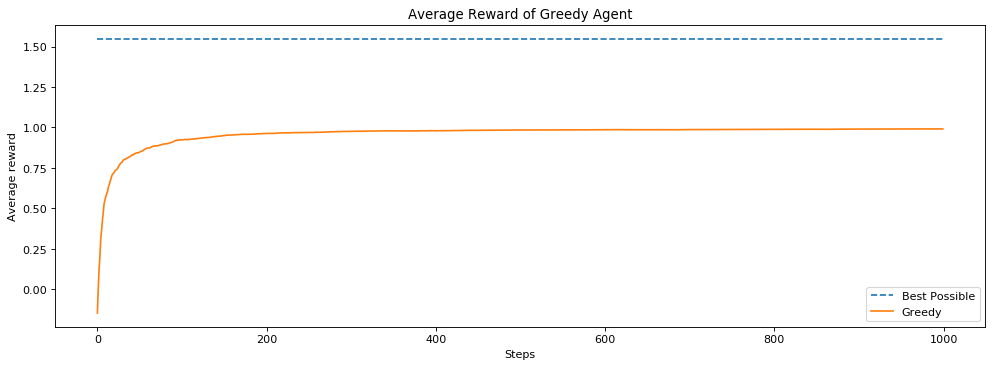

In [40]:
# Plot Greedy Result
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of steps each experiment is run for
env = ten_arm_env.Environment     # We the environment to use
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # Pass the agent the information it needs; 
                                  # here it just needs the number of actions (number of arms).
env_info = {}                     # Pass the environment the information it needs; in this case, it is nothing.

all_averages = []

for i in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below once the code is run
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # Pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # Start the experiment

    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
np.save("greedy_scores", greedy_scores)

## 5. Epsilon-Greedy Agent

A veces es necesaria una acción exploratoria. Esto es para descubrir cuál es la mejor acción. Si siempre elegimos cuál creemos que es la mejor acción actual, podemos perder la mejor acción verdadera, porque no hemos explorado suficientes veces para encontrar esa mejor acción.

In [41]:
# Epsilon Greedy Agent here [Graded]
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Update action-values - this should be the same update as your greedy agent above
        # (~3-5 lines)
       
        ### START CODE HERE ###
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += (1/self.arm_count[self.last_action]) * (reward - self.q_values[self.last_action])
        ### END CODE HERE ###
        
        # Choose action using epsilon greedy
        # Randomly choose a number between 0 and 1 and see if it is less than self.epsilon
        # (Hint: look at np.random.random()). If it is, set current_action to a random action.
        # Otherwise choose current_action greedily as you did above.
        # (~4 lines)
        ### START CODE HERE ###
        random_n = np.random.random()
        if random_n < self.epsilon:
            current_action = np.random.randint(0 , len(self.arm_count) - 1)
        else:
            current_action = argmax(self.q_values)
        ### END CODE HERE ###
        
        
        self.last_action = current_action
        
        return current_action

In [42]:
# Do not modify this cell
# Test Code for Epsilon Greedy Agent
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5
action = e_greedy_agent.agent_step(1, 0)
print("Output:")
print(e_greedy_agent.q_values)
print("Expected Output:")
print([0, 0.5, 1.0, 0, 0])

# assert action == 2, "Check that you are using argmax to choose the action with the highest value."
assert e_greedy_agent.q_values == [0, 0.5, 1.0, 0, 0], "Check that you are updating q_values correctly."

Output:
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]


## 6. Grafica Agente Greedy vs  Agente Greedy con epsilon de 0.1

100%|██████████| 200/200 [00:04<00:00, 49.96it/s]


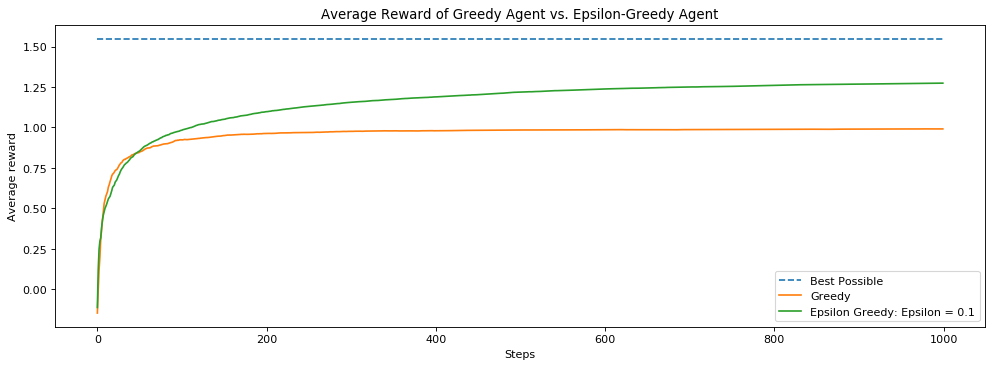

In [43]:
# Plot Epsilon greedy results and greedy results
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_averages = []

for i in tqdm(range(num_runs)):
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. Epsilon-Greedy Agent")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Best Possible", "Greedy", "Epsilon Greedy: Epsilon = 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
np.save("e-greedy", all_averages)

## 7. Promedio de multiples ejecuciones

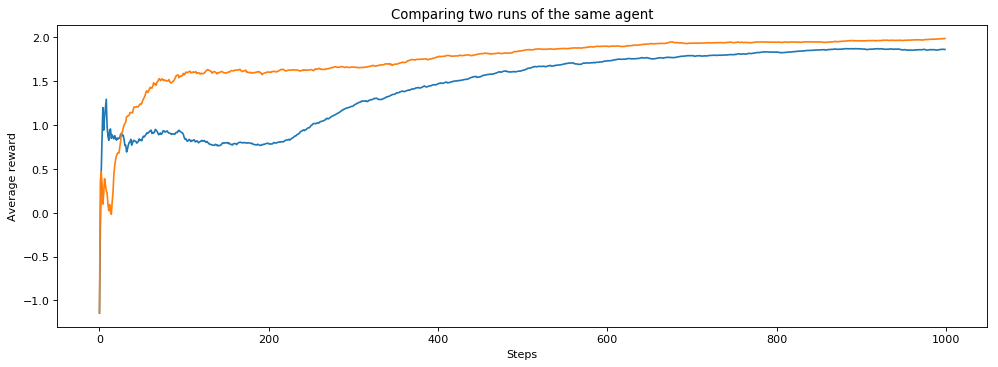

In [44]:
# Plot runs of e-greedy agent
agent = EpsilonGreedyAgent
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    np.random.seed(run) # Here we set the seed so that we can compare two different runs
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
#     all_averages.append(averages)
    plt.plot(averages)

# plt.plot(greedy_scores)
plt.title("Comparing two runs of the same agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
# plt.plot(np.mean(all_averages, axis=0))
# plt.legend(("Greedy", "Epsilon: 0.1"))
plt.show()

## 8. Acciones a partir de diferentes semillas.

In [45]:
print("Random Seed 1")
np.random.seed(1)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")
    

print()
print()

print("Random Seed 2")
np.random.seed(2)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")

Random Seed 1
Exploratory Action
Exploratory Action
Exploratory Action


Random Seed 2
Exploratory Action


With the first seed, we take an exploratory action three times out of 15, but with the second, we only take an exploratory action once. This can significantly affect the performance of our agent because the amount of exploration has changed significantly.

To compare algorithms, we therefore report performance averaged across many runs. We do this to ensure that we are not simply reporting a result that is due to stochasticity, as explained [in the lectures](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/lecture/PtVBs/sequential-decision-making-with-evaluative-feedback). Rather, we want statistically significant outcomes. We will not use statistical significance tests in this course. Instead, because we have access to simulators for our experiments, we use the simpler strategy of running for a large number of runs and ensuring that the confidence intervals do not overlap. 

## 9. Comparar valores del epsilon

100%|██████████| 200/200 [00:03<00:00, 56.62it/s]


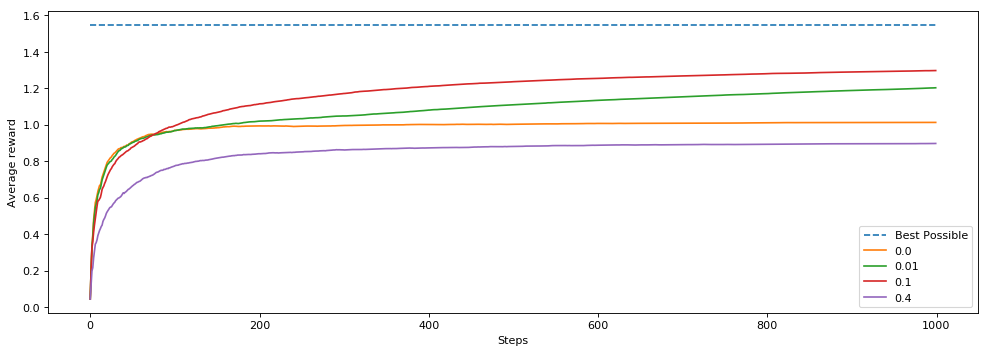

In [46]:
# Experiment code for epsilon-greedy with different values of epsilon
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

## 10. El efecto del tamaño del paso 

In [49]:
# Constant Step Size Agent Here [Graded]
# Greedy agent here
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        # self.step_size : A float which is the current step size for the agent.
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += self.step_size * (reward - self.q_values[self.last_action])
        # Update q_values for action taken at previous time step 
        # using self.step_size intead of using self.arm_count
        # (~1-2 lines)
        ### START CODE HERE ###
        random_n = np.random.random()
        if random_n < self.epsilon:
            current_action = np.random.randint(0 , len(self.arm_count) - 1)
        else:
            current_action = argmax(self.q_values)
        ### END CODE HERE ###
        
        # Choose action using epsilon greedy. This is the same as you implemented above.
        # (~4 lines)
        ### START CODE HERE ###
        
        ### END CODE HERE ###
        
        self.last_action = current_action
        
        return current_action

In [50]:
# Do not modify this cell
# Test Code for Epsilon Greedy with Different Constant Stepsizes
for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    # e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    action = e_greedy_agent.agent_step(1, 0)
    print("Output for step size: {}".format(step_size))
    print(e_greedy_agent.q_values)
    print("Expected Output:")
    print([0, step_size, 1.0, 0, 0])
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0], "Check that you are updating q_values correctly using the stepsize."

Output for step size: 0.01
[0, 0.01, 1.0, 0, 0]
Expected Output:
[0, 0.01, 1.0, 0, 0]
Output for step size: 0.1
[0, 0.1, 1.0, 0, 0]
Expected Output:
[0, 0.1, 1.0, 0, 0]
Output for step size: 0.5
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]
Output for step size: 1.0
[0, 1.0, 1.0, 0, 0]
Expected Output:
[0, 1.0, 1.0, 0, 0]


## 11. Grafico de un cambio en el tamaño del paso

100%|██████████| 200/200 [00:04<00:00, 47.76it/s]


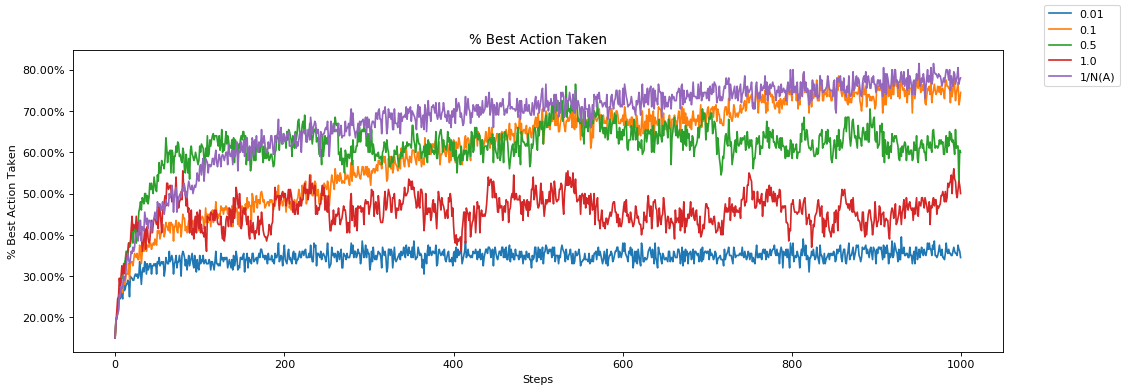

In [51]:
# Experiment code for different step sizes [graded]
step_sizes = [0.01, 0.1, 0.5, 1.0]

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgentConstantStepsize
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        
        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))
    if step_size == 0.01:
        np.save("step_size", best_actions[step_size])
    
ax.plot(np.mean(n_best_actions, axis=0))
fig.legend(step_sizes + ["1/N(A)"])
plt.title("% Best Action Taken")
plt.xlabel("Steps")
plt.ylabel("% Best Action Taken")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

## 12. Graficos con diferentes pasos

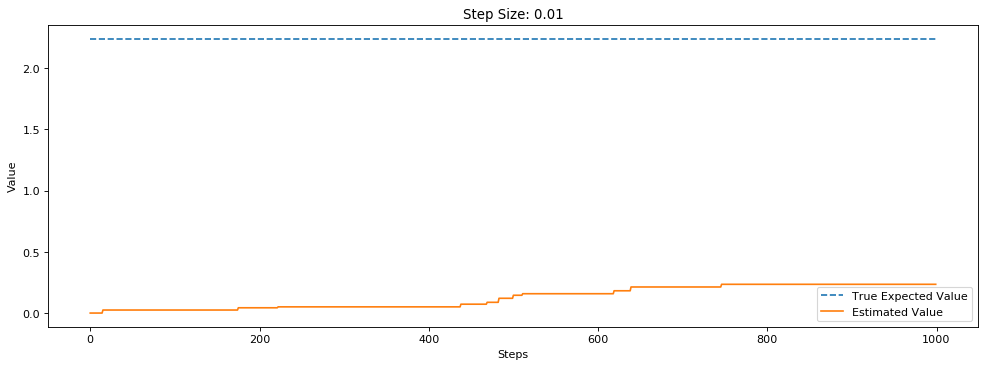

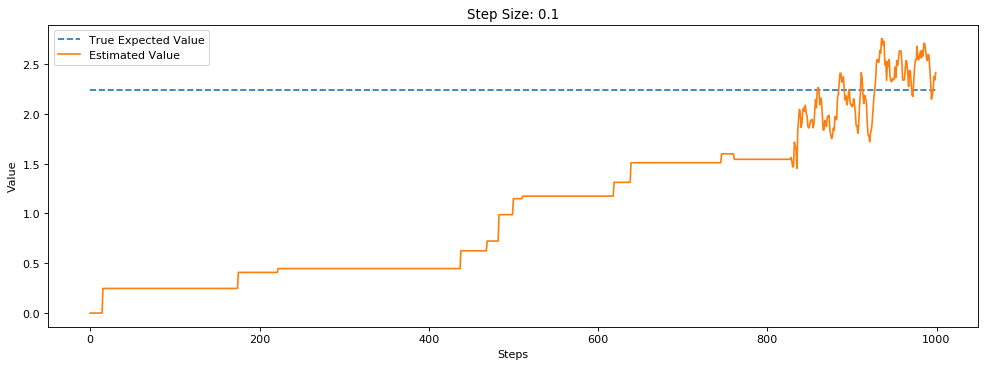

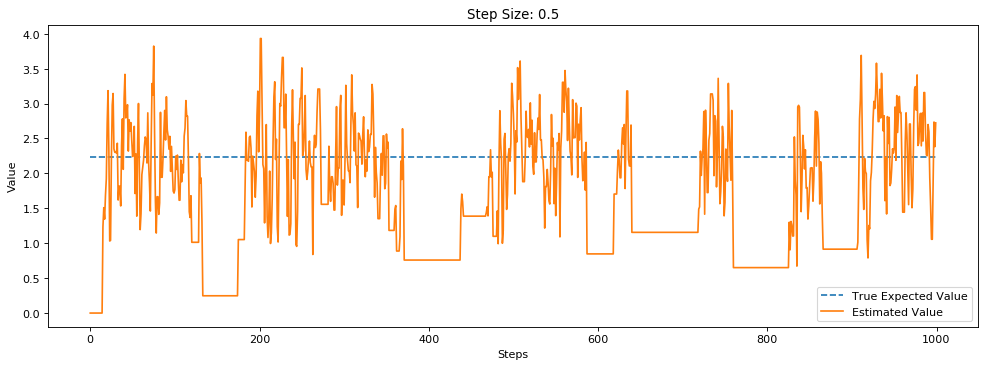

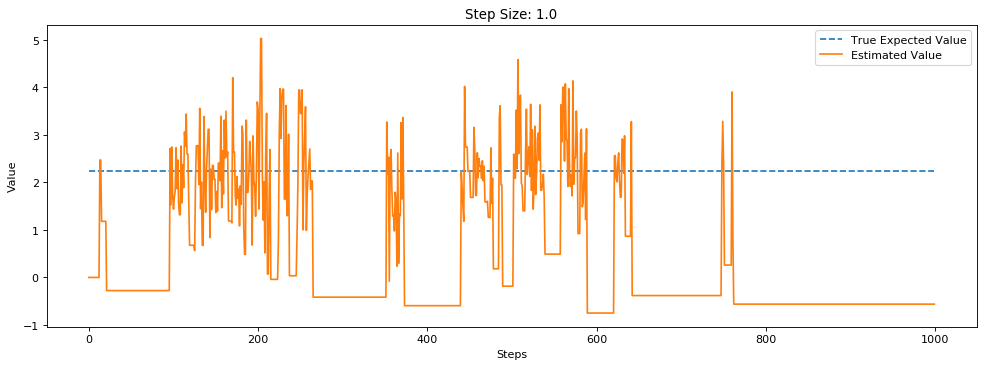

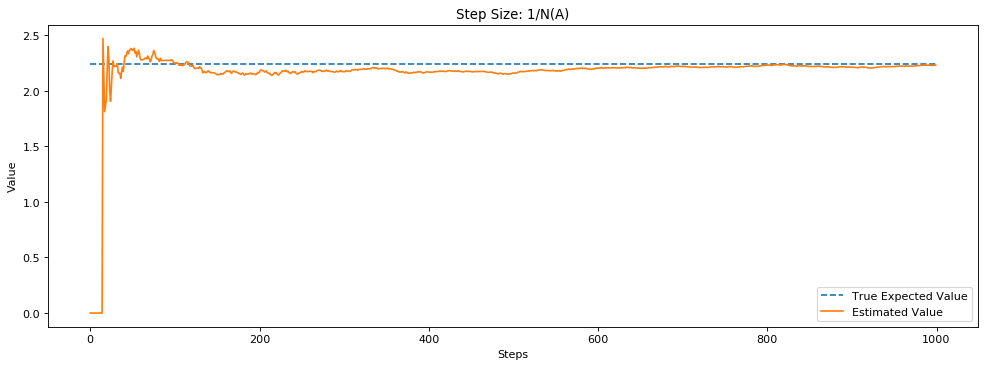

In [52]:
# Plot various step sizes and estimates
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Step Size: 1/N(A)")
plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
plt.plot(np.array(n_q_values)[:, largest])
plt.legend(["True Expected Value", "Estimated Value"])
plt.xlabel("Steps")
plt.ylabel("Value")
plt.show()

## 13. Grafico de tamaño constate vs tamaño decreciente

100%|██████████| 200/200 [00:08<00:00, 24.71it/s]


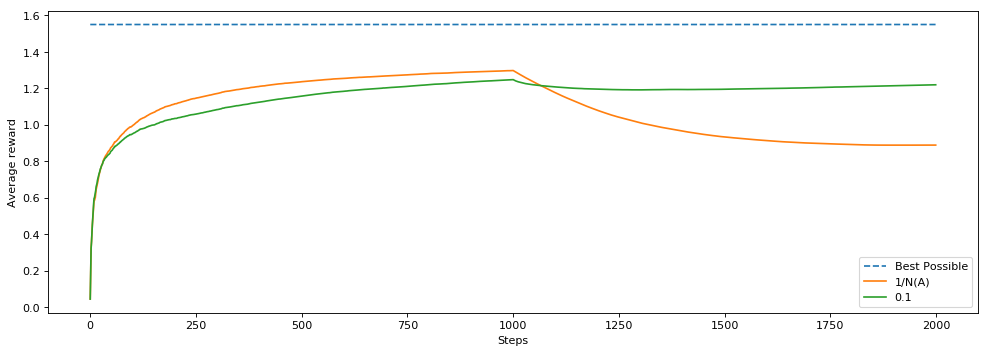

In [53]:
epsilon = 0.1
num_steps = 2000
num_runs = 200
step_size = 0.1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        scores = [0]
        averages = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "1/N(A)", "0.1"])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Now the agent with a step size of 1/N(A) performed better at the start but then performed worse when the environment changed! What happened?

Think about what the step size would be after 1000 steps. Let's say the best action gets chosen 500 times. That means the step size for that action is 1/500 or 0.002. At each step when we update the value of the action and the value is going to move only 0.002 * the error. That is a very tiny adjustment and it will take a long time for it to get to the true value.

The agent with step size 0.1, however, will always update in 1/10th of the direction of the error. This means that on average it will take ten steps for it to update its value to the sample mean.

These are the types of tradeoffs we have to think about in reinforcement learning. A larger step size moves us more quickly toward the true value, but can make our estimated values oscillate around the expected value. A step size that reduces over time can converge to close to the expected value, without oscillating. On the other hand, such a decaying stepsize is not able to adapt to changes in the environment. Nonstationarity---and the related concept of partial observability---is a common feature of reinforcement learning problems and when learning online.  